In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from pprint import pprint

In [2]:
pd.set_option('display.max_columns', None)

In [138]:
data = pd.read_excel('data/data.xlsx')

## Data cleaning and feature selection

In [139]:
# Adding monthly Macro-variables #
macro = pd.read_excel('data/UAE_Monthly1.xlsx')
macro['DateTime'] = macro['DateTime'].astype('datetime64')

data['inflation_rate'] = np.zeros(len(data))
data['manufacturing_PMI'] = np.zeros(len(data))

for i in data.index:
    for j in macro.index:
        if data.loc[i, 'date_of_disbursement'].year == macro.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro.loc[j, 'DateTime'].month:
            data.at[i, 'inflation_rate']    = macro.loc[j, 'Inflation Rate']
            data.at[i, 'manufacturing_PMI'] = macro.loc[j, 'Manufacturing PMI']
            break

In [140]:
# Adding quarterly Macro-variables #
macro2 = pd.read_excel('data/UAE_quarter1.xlsx')
macro2['DateTime'] = macro2['DateTime'].astype('datetime64')

data['CPI'] = [ np.nan for i in data.index]

for i in data.index:
    for j in macro2.index:
        if data.loc[i, 'date_of_disbursement'].year == macro2.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro2.loc[j, 'DateTime'].month:
            data.at[i, 'CPI'] = macro2.loc[j, 'Consumer Price Index CPI']
            break

In [141]:
data_macro = data.copy()

---

In [142]:
# Creating target columns #
data_macro['max_90_bad'] = (data_macro['max_dpd_3_year'] >= 90).astype(int)
data_macro['cmltv_90_bad'] = (data_macro['cumulative_days_of_late_payments_throughout_loan_repayments'] >= 90).astype(int)

print(data_macro['cmltv_90_bad'].value_counts())

0    2646
1     543
Name: cmltv_90_bad, dtype: int64


In [273]:
target = 'cmltv_90_bad'

cat_feats = [
    'location',
    'emirates',
    'gender',
    'family_status',
    'employment_sphere',
    'collateral',
    'type_of_product',
    'employment_level'
]
num_feats = [
    'loan_amount',
    'duration_at_disbursement_months',
    'interest_rate',
    'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
    'age',
    'monthly_income_aed',
    'work_experience',
    'inflation_rate',
    'manufacturing_PMI',
    'presence_of_car',
    'presence_of_housing',
    'CPI'
]

ignore_feats = [
    'client_id',
    'loan_currency',
    'date_of_disbursement',
    'date_of_closure_based_on_contract',
    'max_dpd_3_year',
    'cumulative_days_of_late_payments_throughout_loan_repayments',
    'status_of_loan',
    'quantity_of_prior_loans_at_cbi',
    'coborrower',
    'top_up',
    'dsr',
    'max_90_bad'
]

In [64]:
data_macro.isna().sum()

client_id                                                        0
loan_currency                                                    0
loan_amount                                                      0
date_of_disbursement                                             0
date_of_closure_based_on_contract                                0
duration_at_disbursement_months                                  0
interest_rate                                                    0
max_dpd_3_year                                                   0
cumulative_days_of_late_payments_throughout_loan_repayments      0
quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi       0
type_of_product                                                  0
status_of_loan                                                   0
location                                                         0
emirates                                                         0
gender                                                        

In [65]:
def isnan(num):
    return num != num

# Converting Work experience feature to the months #
for i in data_macro.index:
    it = data_macro.loc[i, 'work_experience']
    years, months, gap, minus = 0, 0, False, False

    if isnan(it):
        continue
    
    # Extracting year and month from the string #
    for j in it :
        if j >= '0' and j <= '9' :
            if not gap :
                years = years*10 + int(j)
            else :
                months = months*10 + int(j)
        elif j == '-' :
            minus = True
            gap = True
        else :
            gap = True
    # Setting the new value to the DataFrame #
    if minus :
        months *= -1
        
    data_macro.at[i, 'work_experience'] = int(years*12 + months)
    
data_macro['work_experience'] = data_macro['work_experience'].astype('float32')

In [66]:
data_macro[data_macro['work_experience'].isna()][['loan_currency', 'interest_rate', 'work_experience']]

,loan_currency,interest_rate,work_experience
85,AED,0.068444,NaN
143,AED,0.080508,NaN
2097,AED,0.045000,NaN
2536,AED,0.120000,NaN


In [67]:
data_macro[['loan_currency', 'interest_rate', 'work_experience']]

,loan_currency,interest_rate,work_experience
0,AED,0.0549,60.0
1,AED,0.0300,229.0
2,AED,0.0457,51.0
3,AED,0.0686,44.0
4,AED,0.0457,436.0
...,...,...,...
3184,AED,0.0750,122.0
3185,AED,0.0600,82.0
3186,AED,0.1150,128.0
3187,AED,0.0550,23.0


In [68]:
data_na = data_macro.dropna(subset=cat_feats+num_feats)

---

In [69]:
# Choosing only Closed loans & Active loans that are already bad #
data_closed_or_bad = data_na[(data_na['status_of_loan'] == 'Active') & (data_na[target] == 1) | (data_na['status_of_loan'] != 'Active')]

In [73]:
data_closed_or_bad.drop(columns="loan_currency", inplace=True)

In [74]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_closed_or_bad, train_size=0.8, random_state=89, stratify=data_closed_or_bad[target])

In [75]:
# Target mean encoding #
cols = cat_feats

for col in cols:
    stats = train[target].groupby(train[col]).agg(['count', 'mean'])
    train[col+'_mean_encoded'] = train[col].copy()
    test[col+'_mean_encoded'] = test[col].copy()
    
    for i in train[col+'_mean_encoded'].unique():
        train[col+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)        
        test[col+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)

In [76]:
# Removing classes that are in test set but not in train set #
for i in test.index :
    for col in cat_feats :
        if type(test[col+'_mean_encoded'][i]) == str:
            test.drop(i,inplace=True)
            break

In [77]:
# We move all categorical variables to numerical list #
for i in cat_feats:
    num_feats.extend( [i+'_mean_encoded'] )
    ignore_feats.extend([i])

cat_feats.clear()

---

In [78]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(train.columns)
dataset_columns.remove(target)

if sorted(all_columns) == sorted(dataset_columns) :
    print( 'All variables are found in feature lists' )
else :
    print('Features found in dataset but not in lists :')
    for i in dataset_columns :
        if i not in all_columns :
            print(i)
    
    print('-'*50)
    print('Features found in lists but not in dataset')
    for i in all_columns :
        if i not in dataset_columns :
            print(i)

Features found in dataset but not in lists :
--------------------------------------------------
Features found in lists but not in dataset
loan_currency


In [79]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(train.columns)
dataset_columns.remove(target)
sorted(all_columns) == sorted(dataset_columns)

False

# Modeling
---

In [94]:
exp = ClassificationExperiment()
exp.setup(
    data=train,
    test_data=test,
    target=target,
    index=False,
    fold_shuffle=True,
    
    # categorical_imputation='mode',
    # numeric_imputation='mean',
    
    categorical_features=cat_feats,
    numeric_features=num_feats,
    ignore_features=ignore_feats,
    ordinal_features={},

    max_encoding_ohe=70,
    
    remove_multicollinearity=True,
    multicollinearity_threshold=0.85,
    
    use_gpu=True,
    memory=False,
    
    session_id=15,
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

,Description,Value
0,Session id,15
1,Target,cmltv_90_bad
2,Target type,Binary
3,Original data shape,"(2679, 40)"
4,Transformed data shape,"(2679, 20)"
5,Transformed train set shape,"(2152, 20)"
6,Transformed test set shape,"(527, 20)"
7,Ignore features,20
8,Numeric features,20
9,Rows with missing values,1.7%


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leav

In [96]:
best = exp.compare_models(sort = 'AUC', include = ['rf', 'gbc', 'catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8415,0.8294,0.3743,0.7036,0.4843,0.4017,0.4316,16.0320
gbc,Gradient Boosting Classifier,0.8397,0.8224,0.3508,0.6989,0.4641,0.3832,0.4156,0.2510
rf,Random Forest Classifier,0.8341,0.7941,0.2932,0.7131,0.4121,0.3358,0.3820,0.1990


In [122]:
# train catboost
trained_model_catboost = exp.create_model(
    estimator='catboost',
    iterations=1000,
    learning_rate=0.01,
    fold=5
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8515,0.8124,0.3678,0.7805,0.5000,0.4257,0.4674
1,0.8260,0.8469,0.2529,0.6875,0.3697,0.2930,0.3426
2,0.8605,0.8267,0.4186,0.7826,0.5455,0.4718,0.5041
3,0.8372,0.8492,0.2791,0.7500,0.4068,0.3346,0.3899
4,0.8465,0.8136,0.3333,0.7838,0.4677,0.3947,0.4441
Mean,0.8443,0.8298,0.3303,0.7569,0.4579,0.3840,0.4296
Std,0.0119,0.0158,0.0597,0.0369,0.0631,0.0637,0.0572


In [123]:
# train gbc
trained_model_gbc = exp.create_model(
    estimator='gbc',
    learning_rate=0.03,
    fold=5
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8492,0.8081,0.2989,0.8667,0.4444,0.3803,0.4530
1,0.8121,0.8146,0.1494,0.6500,0.2430,0.1812,0.2463
2,0.8488,0.8049,0.3023,0.8387,0.4444,0.3786,0.4451
3,0.8302,0.8254,0.2093,0.7826,0.3303,0.2685,0.3462
4,0.8349,0.8005,0.2414,0.8077,0.3717,0.3072,0.3823
Mean,0.8350,0.8107,0.2403,0.7891,0.3668,0.3032,0.3746
Std,0.0137,0.0087,0.0574,0.0751,0.0758,0.0745,0.0754


In [124]:
# train rf
trained_model_rf = exp.create_model(
    estimator='rf',
    fold=5
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8585,0.7887,0.4023,0.7955,0.5344,0.4613,0.4987
1,0.8144,0.7630,0.2299,0.6061,0.3333,0.2501,0.2900
2,0.8465,0.7804,0.3605,0.7381,0.4844,0.4065,0.4426
3,0.8372,0.8022,0.2674,0.7667,0.3966,0.3269,0.3880
4,0.8349,0.7852,0.3103,0.7105,0.4320,0.3523,0.3939
Mean,0.8383,0.7839,0.3141,0.7234,0.4361,0.3594,0.4026
Std,0.0146,0.0127,0.0620,0.0651,0.0695,0.0716,0.0690


In [125]:
# GET PERFORMANCE METRICS:
threshold = 0.25
predictions = exp.predict_model(trained_model_catboost, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8235,0.7715,0.2190,0.6765,0.3309,0.2587,0.3138


{'0': {'precision': 0.8669950738916257,
       'recall': 0.8341232227488151,
       'f1-score': 0.8502415458937197,
       'support': 422},
 '1': {'precision': 0.4214876033057851,
       'recall': 0.4857142857142857,
       'f1-score': 0.45132743362831856,
       'support': 105},
 'accuracy': 0.7647058823529411,
 'macro avg': {'precision': 0.6442413385987054,
               'recall': 0.6599187542315504,
               'f1-score': 0.6507844897610191,
               'support': 527},
 'weighted avg': {'precision': 0.7782317258621887,
                  'recall': 0.7647058823529411,
                  'f1-score': 0.7707615045505183,
                  'support': 527},
 'threshold': 0.25,
 'TN': 352,
 'FP': 70,
 'FN': 54,
 'TP': 51,
 'AUC': 0.7716,
 'model NPL': 13.3,
 ' real NPL': 19.92,
 'approval rate': 77.04,
 'good correct': 83.41,
 'bad correct': 48.57}


In [126]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(trained_model_catboost, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8235,0.7715,0.2190,0.6765,0.3309,0.2587,0.3138


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.580645,0.771564,213.0,209.0,12.0,93.0
1,0.15,0.673624,0.771564,280.0,142.0,30.0,75.0
2,0.20,0.724858,0.771564,320.0,102.0,43.0,62.0
3,0.25,0.764706,0.771564,352.0,70.0,54.0,51.0
4,0.30,0.776091,0.771564,369.0,53.0,65.0,40.0


In [114]:
# GET PERFORMANCE METRICS:
threshold = 0.25
predictions = exp.predict_model(trained_model_gbc, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8216,0.7418,0.1810,0.7037,0.2879,0.2247,0.2935


{'0': {'precision': 0.8619854721549637,
       'recall': 0.8436018957345972,
       'f1-score': 0.8526946107784431,
       'support': 422},
 '1': {'precision': 0.42105263157894735,
       'recall': 0.45714285714285713,
       'f1-score': 0.4383561643835617,
       'support': 105},
 'accuracy': 0.7666034155597723,
 'macro avg': {'precision': 0.6415190518669556,
               'recall': 0.6503723764387271,
               'f1-score': 0.6455253875810024,
               'support': 527},
 'weighted avg': {'precision': 0.7741335779225506,
                  'recall': 0.7666034155597723,
                  'f1-score': 0.7701414098838273,
                  'support': 527},
 'threshold': 0.25,
 'TN': 356,
 'FP': 66,
 'FN': 57,
 'TP': 48,
 'AUC': 0.7418,
 'model NPL': 13.8,
 ' real NPL': 19.92,
 'approval rate': 78.37,
 'good correct': 84.36,
 'bad correct': 45.71}


In [115]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(trained_model_gbc, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8216,0.7418,0.1810,0.7037,0.2879,0.2247,0.2935


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.438330,0.741808,132.0,290.0,6.0,99.0
1,0.15,0.620493,0.741808,255.0,167.0,33.0,72.0
2,0.20,0.696395,0.741808,309.0,113.0,47.0,58.0
3,0.25,0.766603,0.741808,356.0,66.0,57.0,48.0
4,0.30,0.808349,0.741808,387.0,35.0,66.0,39.0


In [117]:
# GET PERFORMANCE METRICS:
threshold = 0.25
predictions = exp.predict_model(trained_model_rf, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8140,0.7639,0.1905,0.6061,0.2899,0.2151,0.2632


{'0': {'precision': 0.8842105263157894,
       'recall': 0.7962085308056872,
       'f1-score': 0.8379052369077307,
       'support': 422},
 '1': {'precision': 0.41496598639455784,
       'recall': 0.580952380952381,
       'f1-score': 0.4841269841269842,
       'support': 105},
 'accuracy': 0.7533206831119544,
 'macro avg': {'precision': 0.6495882563551736,
               'recall': 0.688580455879034,
               'f1-score': 0.6610161105173574,
               'support': 527},
 'weighted avg': {'precision': 0.790717781170193,
                  'recall': 0.7533206831119544,
                  'f1-score': 0.7674181087445838,
                  'support': 527},
 'threshold': 0.25,
 'TN': 336,
 'FP': 86,
 'FN': 44,
 'TP': 61,
 'AUC': 0.7639,
 'model NPL': 11.58,
 ' real NPL': 19.92,
 'approval rate': 72.11,
 'good correct': 79.62,
 'bad correct': 58.1}


In [118]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(trained_model_rf, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8140,0.7639,0.1905,0.6061,0.2899,0.2151,0.2632


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.508539,0.763947,173.0,249.0,10.0,95.0
1,0.15,0.614801,0.763947,242.0,180.0,23.0,82.0
2,0.20,0.686907,0.763947,293.0,129.0,36.0,69.0
3,0.25,0.753321,0.763947,336.0,86.0,44.0,61.0
4,0.30,0.779886,0.763947,364.0,58.0,58.0,47.0


In [135]:
three_models = exp.blend_models([trained_model_catboost,trained_model_gbc, trained_model_rf])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8426,0.8036,0.2727,0.8571,0.4138,0.3499,0.4271
1,0.8565,0.8178,0.3636,0.8421,0.5079,0.4390,0.4923
2,0.8372,0.8341,0.2791,0.7500,0.4068,0.3346,0.3899
3,0.8186,0.8125,0.1628,0.7000,0.2642,0.2041,0.2761
4,0.8605,0.8487,0.3721,0.8421,0.5161,0.4485,0.4998
5,0.8465,0.7927,0.3721,0.7273,0.4923,0.4128,0.4450
6,0.8372,0.8311,0.2791,0.7500,0.4068,0.3346,0.3899
7,0.8326,0.8422,0.2326,0.7692,0.3571,0.2913,0.3610
8,0.8465,0.8158,0.3488,0.7500,0.4762,0.4000,0.4404


In [137]:
# GET PERFORMANCE METRICS:
threshold = 0.25
predictions = exp.predict_model(three_models, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8159,0.7753,0.1619,0.6538,0.2595,0.1960,0.2593


{'0': {'precision': 0.8737864077669902,
       'recall': 0.8530805687203792,
       'f1-score': 0.8633093525179856,
       'support': 422},
 '1': {'precision': 0.4608695652173913,
       'recall': 0.5047619047619047,
       'f1-score': 0.4818181818181818,
       'support': 105},
 'accuracy': 0.7836812144212524,
 'macro avg': {'precision': 0.6673279864921908,
               'recall': 0.6789212367411419,
               'f1-score': 0.6725637671680837,
               'support': 527},
 'weighted avg': {'precision': 0.7915164486252295,
                  'recall': 0.7836812144212524,
                  'f1-score': 0.7873006752438311,
                  'support': 527},
 'threshold': 0.25,
 'TN': 360,
 'FP': 62,
 'FN': 52,
 'TP': 53,
 'AUC': 0.7753,
 'model NPL': 12.62,
 ' real NPL': 19.92,
 'approval rate': 78.18,
 'good correct': 85.31,
 'bad correct': 50.48}


In [136]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(three_models, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8159,0.7753,0.1619,0.6538,0.2595,0.1960,0.2593


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.521822,0.77531,177.0,245.0,7.0,98.0
1,0.15,0.647059,0.77531,258.0,164.0,22.0,83.0
2,0.20,0.721063,0.77531,313.0,109.0,38.0,67.0
3,0.25,0.783681,0.77531,360.0,62.0,52.0,53.0
4,0.30,0.800759,0.77531,379.0,43.0,62.0,43.0


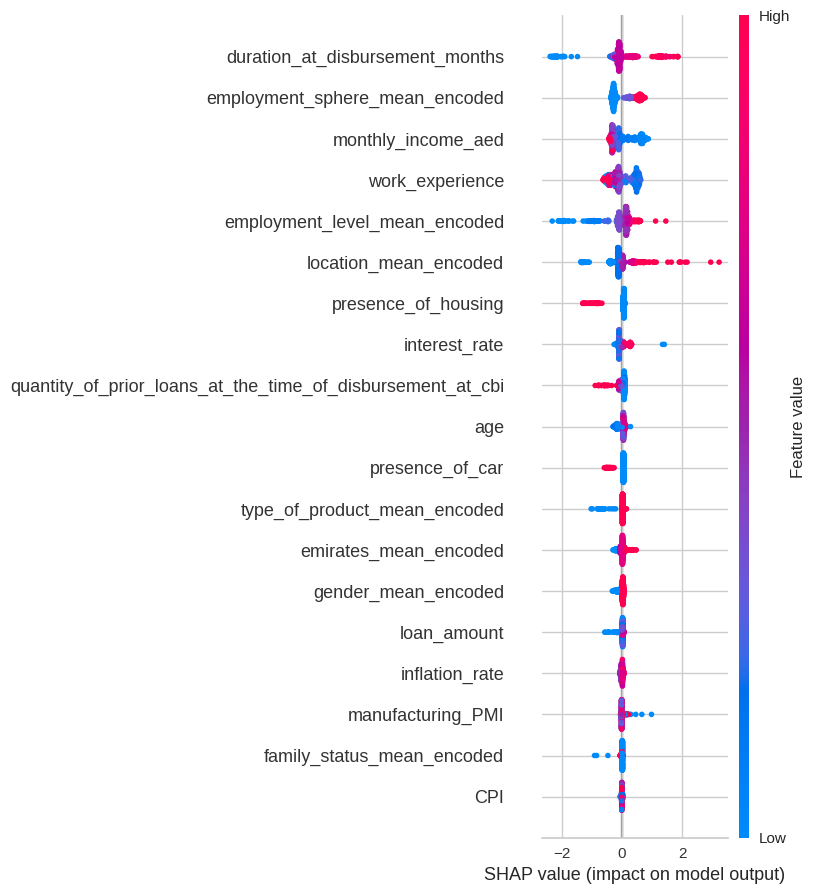

In [146]:
exp.interpret_model(trained_model_catboost)

In [184]:
blind = pd.read_excel('data/blind_set.xlsx')

In [185]:
# Adding monthly Macro-variables #
macro = pd.read_excel('data/UAE_Monthly1.xlsx')
macro['DateTime'] = macro['DateTime'].astype('datetime64')

blind['inflation_rate'] = np.zeros(len(blind))
blind['manufacturing_PMI'] = np.zeros(len(blind))

for i in blind.index:
    for j in macro.index:
        if blind.loc[i, 'date_of_disbursement'].year == macro.loc[j, 'DateTime'].year and blind.loc[i, 'date_of_disbursement'].month == macro.loc[j, 'DateTime'].month:
            blind.at[i, 'inflation_rate']    = macro.loc[j, 'Inflation Rate']
            blind.at[i, 'manufacturing_PMI'] = macro.loc[j, 'Manufacturing PMI']
            break

In [186]:
# Adding quarterly Macro-variables #
macro2 = pd.read_excel('data/UAE_quarter1.xlsx')
macro2['DateTime'] = macro2['DateTime'].astype('datetime64')

blind['CPI'] = [ np.nan for i in blind.index]

for i in blind.index:
    for j in macro2.index:
        if blind.loc[i, 'date_of_disbursement'].year == macro2.loc[j, 'DateTime'].year and blind.loc[i, 'date_of_disbursement'].month == macro2.loc[j, 'DateTime'].month:
            blind.at[i, 'CPI'] = macro2.loc[j, 'Consumer Price Index CPI']
            break

In [187]:
blind_macro = blind.copy()

In [188]:
def isnan(num):
    return num != num

# Converting Work experience feature to the months #
for i in blind_macro.index:
    it = blind_macro.loc[i, 'work_experience']
    years, months, gap, minus = 0, 0, False, False

    if isnan(it):
        continue
    
    # Extracting year and month from the string #
    for j in it :
        if j >= '0' and j <= '9' :
            if not gap :
                years = years*10 + int(j)
            else :
                months = months*10 + int(j)
        elif j == '-' :
            minus = True
            gap = True
        else :
            gap = True
    # Setting the new value to the DataFrame #
    if minus :
        months *= -1
        
    blind_macro.at[i, 'work_experience'] = int(years*12 + months)
    
blind_macro['work_experience'] = blind_macro['work_experience'].astype('float32')

In [190]:
# Target mean encoding #
cols = cat_feats


for col in cols:
    # Рассчитываем статистику на обучающем наборе
    stats = train.groupby(train[col])[target].agg(['mean'])
    
    # Создаем новый mean-encoded признак в блайндсете test
    blind_macro[col+'_mean_encoded'] = blind_macro[col].map(stats['mean'])

In [191]:
# Removing classes that are in test set but not in train set #
for i in blind_macro.index :
    for col in cat_feats :
        if type(blind_macro[col+'_mean_encoded'][i]) == str:
            blind_macro.drop(i,inplace=True)
            break
        
# We move all categorical variables to numerical list #
for i in cat_feats:
    num_feats.extend( [i+'_mean_encoded'] )
    ignore_feats.extend([i])

cat_feats.clear()

In [214]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(three_models, data=blind_macro, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    
predictions

,client_id,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,type_of_product,...,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded,prediction_label,prediction_score_0,prediction_score_1
0,9831,319600.000000,2023-01-02,2027-12-30,60,0.0686,NaN,NaN,0,CAR LOAN,...,0.201117,0.182500,0.194892,0.333333,0.205486,0.107143,NaN,0,0.7722,0.2278
1,9805,269000.000000,2022-05-05,2026-04-01,48,0.0594,NaN,NaN,0,CAR LOAN,...,0.204013,0.205479,0.194892,0.154460,0.205486,0.107143,0.163043,0,0.9573,0.0427
2,9780,384000.000000,2022-03-29,2026-03-01,48,0.0503,NaN,NaN,0,CAR LOAN,...,0.204013,0.182500,0.194892,0.154460,0.205486,0.107143,0.121212,0,0.9696,0.0304
3,9772,239200.000000,2021-10-14,2026-10-01,60,0.0411,NaN,NaN,0,CAR LOAN,...,0.191601,0.205479,0.194892,0.154460,0.205486,0.107143,0.121212,0,0.9142,0.0858
4,9269,1000000.000000,2022-03-31,2026-03-01,48,0.0595,NaN,NaN,2,CAR LOAN,...,0.204013,0.205479,0.194892,0.333333,0.205486,0.107143,NaN,0,0.9170,0.0830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122,7183,349000.000000,2018-02-25,2022-02-01,48,0.0650,NaN,NaN,2,PERSONAL LOAN,...,0.204771,0.205479,0.194892,0.313761,0.205486,0.206442,0.205882,1,0.5525,0.4475
2123,7188,190000.000000,2018-05-21,2022-04-29,48,0.1200,NaN,NaN,2,PERSONAL LOAN,...,0.191601,0.205479,NaN,0.313761,0.205486,0.206442,0.181818,0,0.7273,0.2727
2124,7185,141510.796875,2019-02-19,2023-07-27,54,0.0675,NaN,NaN,2,PERSONAL LOAN,...,0.191601,0.205479,0.194892,0.154460,0.205486,0.206442,0.000000,0,0.9144,0.0856
2125,7186,225000.000000,2017-09-10,2021-09-02,48,0.0700,NaN,NaN,1,PERSONAL LOAN,...,0.204771,0.205479,0.242515,0.313761,0.205486,0.206442,0.157434,0,0.8391,0.1609


In [215]:
predictions['prediction_score_0'].to_csv('ansemble_pd.csv', index=None)

In [222]:
train.columns

Index(['client_id', 'loan_amount', 'date_of_disbursement',
       'date_of_closure_based_on_contract', 'duration_at_disbursement_months',
       'interest_rate', 'max_dpd_3_year',
       'cumulative_days_of_late_payments_throughout_loan_repayments',
       'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
       'type_of_product', 'status_of_loan', 'location', 'emirates', 'gender',
       'age', 'family_status', 'monthly_income_aed',
       'quantity_of_prior_loans_at_cbi', 'employment_sphere',
       'employment_level', 'work_experience', 'presence_of_car',
       'presence_of_housing', 'coborrower', 'collateral', 'top_up', 'dsr',
       'inflation_rate', 'manufacturing_PMI', 'CPI', 'max_90_bad',
       'cmltv_90_bad', 'location_mean_encoded', 'emirates_mean_encoded',
       'gender_mean_encoded', 'family_status_mean_encoded',
       'employment_sphere_mean_encoded', 'collateral_mean_encoded',
       'type_of_product_mean_encoded', 'employment_level_mean_encoded'],
      d

### Check some variables of train and blind set

In [247]:
def plot_comparing_hists(first_data: pd.DataFrame, second_data: pd.DataFrame, num_rows: int = 2, num_columns: int = 3):

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(8, 6))

    axes = axes.flatten()
    
    # Plot histograms for dataset 1
    axes[0][0].hist(train['loan_amount'], bins=20, edgecolor='k')
    axes[0][0].set_title('Dataset 1 Distribution')

    # Plot histograms for dataset 2
    axes[0][1].hist(blind_macro['loan_amount'], bins=20, edgecolor='k')
    axes[0][1].set_title('Dataset 2 Distribution')

    # Plot histograms for dataset 3
    axes[1][0].hist(train['interest_rate'], bins=20, edgecolor='k')
    axes[1][0].set_title('Dataset 3 Distribution')

    axes[1][1].hist(blind_macro['interest_rate'], bins=20, edgecolor='k')
    axes[1][1].set_title('Dataset 3 Distribution')

    plt.tight_layout()
    plt.show()

In [245]:
num_feats[:-8]

['loan_amount',
 'duration_at_disbursement_months',
 'interest_rate',
 'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
 'age',
 'monthly_income_aed',
 'work_experience',
 'inflation_rate',
 'manufacturing_PMI',
 'presence_of_car',
 'presence_of_housing',
 'CPI']

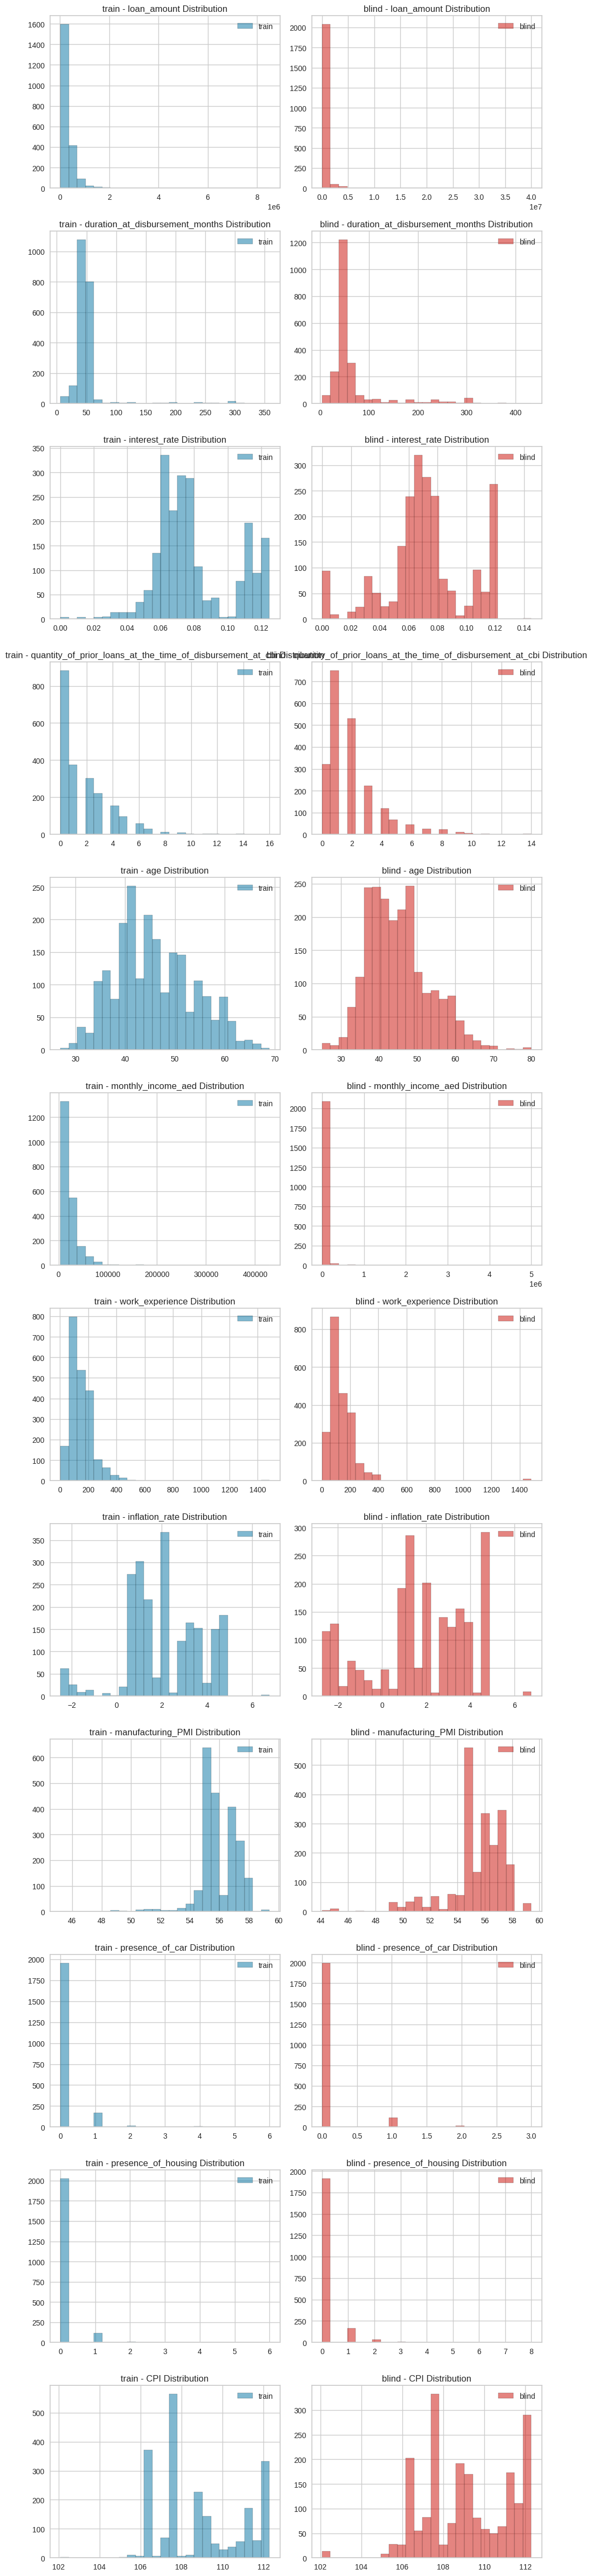

In [260]:
def compare_numeric_distributions(dataset1, dataset2, columns_to_compare):
    """
    Compare the distributions of numeric columns of two datasets using histograms.

    Args:
        dataset1 (pandas.DataFrame): The first dataset.
        dataset2 (pandas.DataFrame): The second dataset.
        columns_to_compare (list of str): A list of column names to compare.

    Returns:
        None
    """
    num_columns = len(columns_to_compare)
    fig, axes = plt.subplots(nrows=num_columns, ncols=2, figsize=(10, 4*num_columns))

    for i, column_name in enumerate(columns_to_compare):
        # Plot histogram for dataset1
        axes[i, 0].hist(dataset1[column_name], bins=25, alpha=0.5, color='b', label='train', edgecolor='k')
        axes[i, 0].set_title(f'train - {column_name} Distribution')
        axes[i, 0].legend()

        # Plot histogram for dataset2
        axes[i, 1].hist(dataset2[column_name], bins=25, alpha=0.5, color='r', label='blind', edgecolor='k')
        axes[i, 1].set_title(f'blind - {column_name} Distribution')
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

# Example usage:

# Define the columns to compare
columns_to_compare = num_feats[:-8]

# Call the compare_numeric_distributions method
compare_numeric_distributions(train, blind_macro, columns_to_compare)


In [264]:
# Summary statistics for dataset 1
summary_train= train[num_feats].describe()

# Summary statistics for dataset 2
summary_blind = blind_macro[num_feats].describe()

# Print summary statistics
print("Train Summary Statistics:")
summary_train


Train Summary Statistics:


,loan_amount,duration_at_disbursement_months,interest_rate,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,age,monthly_income_aed,work_experience,inflation_rate,manufacturing_PMI,presence_of_car,presence_of_housing,CPI,location_mean_encoded,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded
count,2.152000e+03,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.00000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000
mean,2.988995e+05,53.352695,0.078748,1.673327,45.874535,22389.235841,148.009293,2.122756,55.987221,0.112918,0.066450,108.91027,0.201208,0.201208,0.201208,0.201208,0.201208,0.201208,0.201208,0.201208
std,3.859707e+05,34.477634,0.022750,2.057218,7.834531,20857.627160,86.204498,1.665606,1.233719,0.423376,0.310589,2.08286,0.102483,0.021384,0.008941,0.021857,0.069491,0.022674,0.023389,0.121472
min,1.500000e+04,6.000000,0.000000,0.000000,27.000000,3500.000000,3.000000,-2.500000,45.200000,0.000000,0.000000,102.09000,0.000000,0.147727,0.182500,0.000000,0.154460,0.081081,0.093333,0.000000
25%,1.250000e+05,48.000000,0.062500,0.000000,40.000000,10515.000000,93.000000,1.100000,55.100000,0.000000,0.000000,107.46000,0.158768,0.191601,0.205479,0.194892,0.154460,0.205486,0.206442,0.157434
50%,2.120000e+05,48.000000,0.072500,1.000000,45.000000,17500.000000,130.000000,2.100000,55.900000,0.000000,0.000000,108.62000,0.158768,0.204013,0.205479,0.194892,0.154460,0.205486,0.206442,0.184739
75%,3.642500e+05,52.000000,0.097000,3.000000,51.000000,26320.845000,189.250000,3.400000,57.000000,0.000000,0.000000,111.08000,0.231959,0.204771,0.205479,0.194892,0.313761,0.205486,0.206442,0.241379
max,8.508500e+06,358.000000,0.125000,16.000000,69.000000,429440.000000,1483.000000,6.770000,59.400000,6.000000,6.000000,112.29000,1.000000,0.272727,0.205479,0.242515,0.428571,0.205486,0.206442,1.000000


In [265]:
print("Train Summary Statistics:")
summary_blind

Train Summary Statistics:


,loan_amount,duration_at_disbursement_months,interest_rate,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,age,monthly_income_aed,work_experience,inflation_rate,manufacturing_PMI,presence_of_car,presence_of_housing,CPI,location_mean_encoded,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded
count,2.127000e+03,2127.000000,2127.000000,2127.000000,2127.000000,2.127000e+03,2126.000000,2064.000000,2127.000000,2127.000000,2127.000000,2035.000000,2093.000000,2127.000000,2127.000000,1700.000000,2123.000000,2127.000000,2127.000000,2008.000000
mean,4.491743e+05,66.183827,0.072311,1.959567,44.990597,3.324612e+04,140.920044,1.716066,55.462341,0.069111,0.136342,109.136590,0.206061,0.202247,0.200758,0.205310,0.259673,0.195543,0.195575,0.275444
std,1.461292e+06,56.300945,0.029286,1.839327,8.127332,1.527293e+05,118.921631,2.196044,2.061262,0.285129,0.484210,2.108378,0.108436,0.018737,0.009287,0.022871,0.075444,0.033744,0.032971,0.268596
min,1.368600e+04,4.000000,0.000000,0.000000,25.000000,0.000000e+00,1.000000,-2.710000,44.100000,0.000000,0.000000,102.090000,0.000000,0.147727,0.182500,0.000000,0.154460,0.081081,0.093333,0.000000
25%,1.184688e+05,48.000000,0.060000,1.000000,39.000000,9.029575e+03,87.000000,0.800000,55.000000,0.000000,0.000000,107.460000,0.158768,0.201117,0.205479,0.194892,0.154460,0.205486,0.206442,0.157434
50%,2.000000e+05,49.000000,0.070000,1.000000,44.000000,1.550000e+04,116.000000,2.100000,55.800000,0.000000,0.000000,108.970000,0.158768,0.204013,0.205479,0.194892,0.313761,0.205486,0.206442,0.184739
75%,3.567973e+05,57.000000,0.082500,2.000000,50.000000,2.500000e+04,180.000000,3.500000,57.000000,0.000000,0.000000,111.400000,0.231959,0.204771,0.205479,0.194892,0.313761,0.205486,0.206442,0.275510
max,4.000000e+07,432.000000,0.145000,14.000000,80.000000,5.000000e+06,1483.000000,6.770000,59.400000,3.000000,8.000000,112.290000,1.000000,0.272727,0.205479,0.242515,0.428571,0.205486,0.206442,1.000000


In [269]:
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp

# Example T-test
t_stat, p_value = ttest_ind(train['age'].dropna(), blind_macro['age'].dropna())
print("T-Test p-value:", p_value)

T-Test p-value: 0.00029546819011051306


In [274]:
cat_feats

['location',
 'emirates',
 'gender',
 'family_status',
 'employment_sphere',
 'collateral',
 'type_of_product',
 'employment_level']

In [312]:
# Calculate Jaccard similarity
def jaccard_similarity_datasets(train, blind, cat_feats):
    comparings_two_cats = {}
    for categories in cat_feats:
        unique_categories1 = set(train[categories].unique())
        unique_categories2 = set(blind[categories].dropna().unique())

        intersection = len(unique_categories1.intersection(unique_categories2))
        union = len(unique_categories1.union(unique_categories2))

        jaccard_similarity = intersection / union
        comparings_two_cats[categories] = jaccard_similarity
    
    return comparings_two_cats


In [313]:
jaccard_similarity_datasets(train, blind_macro, cat_feats)

{'location': 0.6436781609195402,
 'emirates': 1.0,
 'gender': 1.0,
 'family_status': 1.0,
 'employment_sphere': 0.7142857142857143,
 'collateral': 1.0,
 'type_of_product': 1.0,
 'employment_level': 0.5531914893617021}